# <font color='#6A5ACD'>Разработка A/B-тестирования для нового алгоритма рекомендаций</font>

Компания, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.


Автор: Романовкская Кристина

Дата: 20.04.2025

### <font color='#6A5ACD'>Гипотезы для A/B-теста: </font>

##### Нулевая гипотеза (H₀): 
* Новый алгоритм рекомендаций не влияет на долю успешных сессий (сессий с 4+ просмотренными страницами). То есть средняя доля успешных сессий в тестовой группе (с новым алгоритмом) равна средней доле успешных сессий в контрольной группе (со старым алгоритмом).


##### Альтернативная гипотеза (H₁): 
* Новый алгоритм рекомендаций увеличивает долю успешных сессий по сравнению со старым алгоритмом. То есть средняя доля успешных сессий в тестовой группе выше, чем в контрольной.
* Учитывая MDE (минимальный детектируемый эффект) в 3%, мы ожидаем, что доля успешных сессий в тестовой группе будет как минимум на 3% выше.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-15 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.power import NormalIndPower
from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# Считываем исторические данные
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [4]:
# Выводим первые пять строк
display(sessions_history.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными

In [5]:
# Рассчитываем количество уникальных сессий для каждого пользователя
session_counts = sessions_history.groupby('user_id')['session_id'].nunique().reset_index()
session_counts.columns = ['user_id', 'session_count']

In [6]:
# Находим пользователя с наибольшим количеством сессий
max_sessions_user = session_counts.loc[session_counts['session_count'].idxmax(), 'user_id']

In [7]:

# Выводим все данные для этого пользователя
user_data = sessions_history[sessions_history['user_id'] == max_sessions_user]
display(user_data)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


In [8]:
# Изучение структуры данных
display(user_data.describe(include='all'))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
count,10,10,10,10,10,10.00000,10.0,10.000000,10,10
unique,1,10,10,10,1,NaN,NaN,NaN,1,1
top,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,NaN,NaN,NaN,CIS,Android
freq,10,1,1,1,10,NaN,NaN,NaN,10,10
mean,NaN,NaN,NaN,NaN,NaN,5.50000,0.0,2.600000,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,3.02765,0.0,0.966092,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.00000,0.0,1.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,3.25000,0.0,2.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,5.50000,0.0,2.500000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,7.75000,0.0,3.000000,NaN,NaN


#### 1.3. Анализ числа регистраций

In [9]:
# Преобразуем session_date в формат даты
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

In [10]:
# Агрегируем данные по дням: уникальные пользователи и зарегистрированные пользователи
daily_stats = sessions_history.groupby('session_date').agg(
    total_users=('user_id', 'nunique'),
    registered_users=('registration_flag', lambda x: x[x == 1].count())
).reset_index()

In [11]:
# Рассчитываем долю зарегистрированных пользователей
daily_stats['registered_share'] = daily_stats['registered_users'] / daily_stats['total_users']

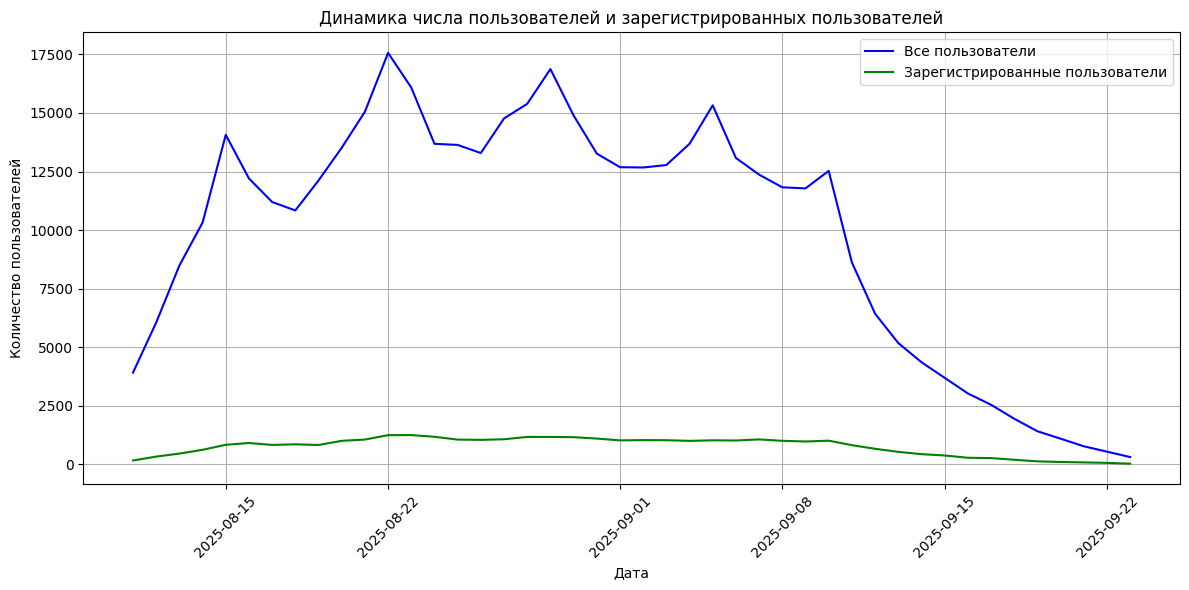

In [12]:
# График 1: Общее число пользователей и зарегистрированных пользователей
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['total_users'], label='Все пользователи', color='blue')
plt.plot(daily_stats['session_date'], daily_stats['registered_users'], label='Зарегистрированные пользователи', color='green')
plt.title('Динамика числа пользователей и зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Количество пользователей')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Низкая конверсия в регистрацию. Большинство пользователей, активно использующих приложение, не регистрируются. Это может быть связано с недостаточной мотивацией для регистрации (например, отсутствие эксклюзивных функций для зарегистрированных пользователей) или сложным процессом регистрации.

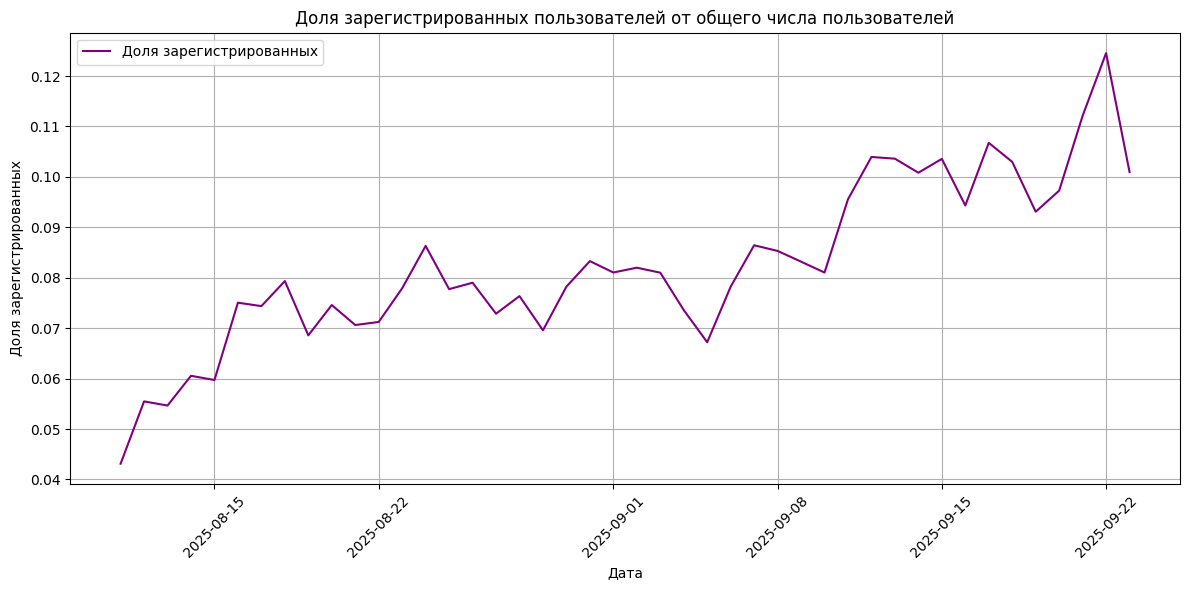

In [13]:
# График 2: Доля зарегистрированных пользователей
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['registered_share'], label='Доля зарегистрированных', color='purple')
plt.title('Доля зарегистрированных пользователей от общего числа пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Доля зарегистрированных пользователей выросла с 4% до 12% за рассматриваемый период, что указывает на улучшение конверсии в регистрацию. Несмотря на рост доли, максимальное значение в 12% всё ещё относительно низкое. Это указывает на возможность дальнейшего увеличения конверсии в регистрацию, особенно если приложение сможет удерживать больше пользователей в периоды спада активности.

In [14]:
# Выводим статистику для проверки
display(daily_stats.head())

,session_date,total_users,registered_users,registered_share
0,2025-08-11,3919,169,0.043123
1,2025-08-12,6056,336,0.055482
2,2025-08-13,8489,464,0.054659
3,2025-08-14,10321,625,0.060556
4,2025-08-15,14065,840,0.059723


#### 1.4. Анализ числа просмотренных страниц

In [15]:
# Находим количество сессий для каждого значения просмотренных страниц
page_counts = sessions_history['page_counter'].value_counts().sort_index()

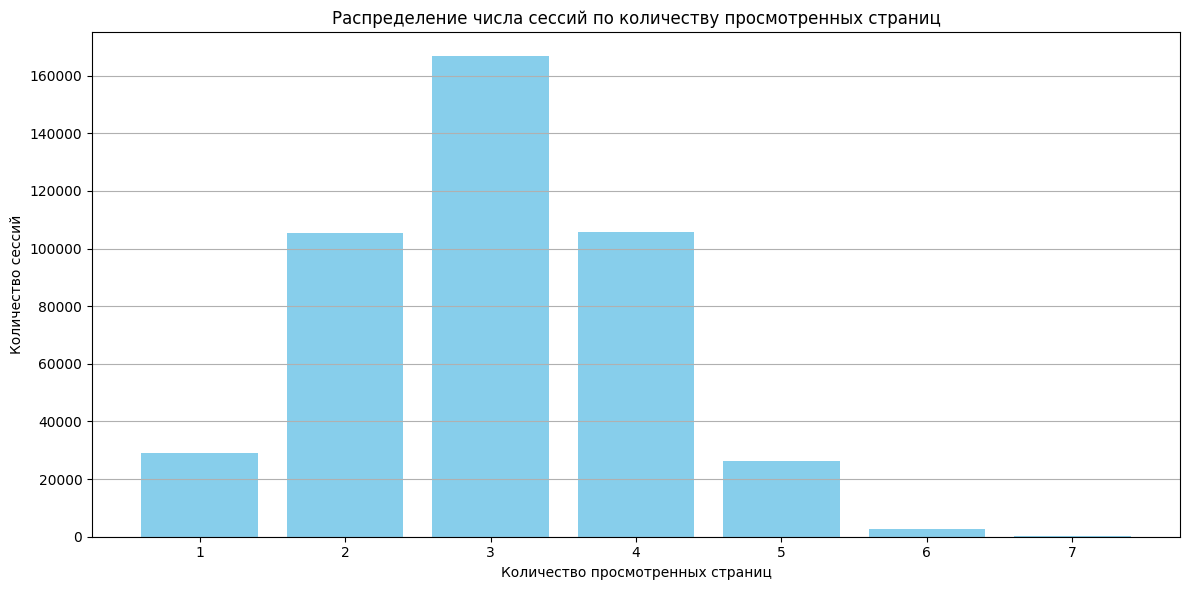

In [16]:
# Строим столбчатую диаграмму
plt.figure(figsize=(12, 6))
plt.bar(page_counts.index, page_counts.values, color='skyblue')
plt.title('Распределение числа сессий по количеству просмотренных страниц')
plt.xlabel('Количество просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Анализ графика и выводы:
1. Большинство сессий короткие. Около 160,000 сессий (пик на графике) имеют 3 просмотренные страницы, что указывает на типичную низкую вовлеченность пользователей.
2. Резкое снижение активности после 3 страниц — лишь ~26,000 сессий с 5 страницами и почти нет сессий с 6+ страницами, показывая, что пользователи редко углубляются в контент.
3. Потенциал для улучшения. Низкое число просмотров страниц (в основном 1–4) говорит о необходимости улучшения контента или интерфейса, чтобы удерживать пользователей дольше.

In [17]:
# Выводим первые несколько строк для проверки
display(page_counts.head(10))

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: count, dtype: int64

#### 1.5. Доля пользователей, просмотревших более четырёх страниц

In [18]:
# Преобразуем session_date в формат даты
sessions_history['session_date'] = pd.to_datetime(sessions_history['session_date'])

In [19]:
# Создаем столбец good_session: 1, если page_counter >= 4, иначе 0
sessions_history['good_session'] = (sessions_history['page_counter'] >= 4).astype(int)

In [20]:
# Агрегируем данные по дням: общее число сессий и число "успешных" сессий
daily_stats = sessions_history.groupby('session_date').agg(
    total_sessions=('session_id', 'count'),
    good_sessions=('good_session', 'sum')
).reset_index()

In [21]:
# Рассчитываем долю успешных сессий
daily_stats['good_session_share'] = daily_stats['good_sessions'] / daily_stats['total_sessions']

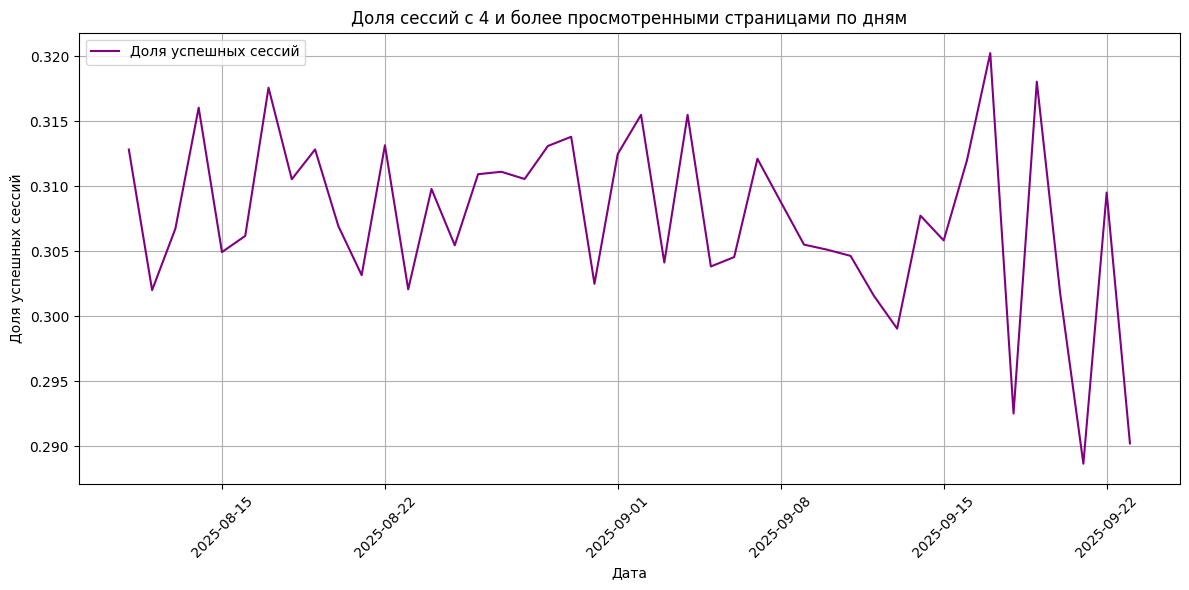

In [22]:
# Строим линейный график
plt.figure(figsize=(12, 6))
plt.plot(daily_stats['session_date'], daily_stats['good_session_share'], label='Доля успешных сессий', color='purple')
plt.title('Доля сессий с 4 и более просмотренными страницами по дням')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Анализ графика и выводы:

1. Стабильная доля успешных сессий. Доля сессий с 4+ просмотренными страницами колеблется в диапазоне 0.29–0.32 (29–32%) без явного тренда роста или спада, указывая на стабильную, но невысокую вовлеченность.
2. Высокая волатильность. Резкие скачки и падения доли (например, пики около 20 августа и 20 сентября) могут быть связаны с изменениями в активности пользователей или качеством контента в отдельные дни.
3. Низкий уровень вовлеченности. Лишь около трети сессий имеют 4+ просмотра страниц, что говорит о недостаточной удовлетворенности большинства пользователей контентом или рекомендациями.

In [23]:
# Выводим первые несколько строк для проверки
display(daily_stats.head())

,session_date,total_sessions,good_sessions,good_session_share
0,2025-08-11,3919,1226,0.312835
1,2025-08-12,6056,1829,0.302015
2,2025-08-13,8489,2604,0.306750
3,2025-08-14,10321,3262,0.316055
4,2025-08-15,14065,4289,0.304941


### 2. Подготовка к тесту

#### 2.1. Расчёт размера выборки
При расчёте размера выборки мы будем использовать метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

In [24]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода
power = 1 - beta  # Мощность теста = 1 - beta = 0.8
mde = 0.03  # Минимальный детектируемый эффект

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = mde,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 17441


#### 2.1. Расчёт длительности A/B-теста

In [25]:
# Рассчитываем количество уникальных пользователей по дням
daily_users = sessions_history.groupby('session_date')['user_id'].nunique().reset_index()

In [26]:
# Находим среднее количество уникальных пользователей в день
avg_daily_users = int(daily_users['user_id'].mean())

In [27]:
# Размер выборки для обеих групп (17,441 для каждой, всего 34,882)
total_sample_size = 17441 * 2

In [28]:
# Рассчитываем длительность теста в днях, округляя вверх
test_duration = ceil(total_sample_size / avg_daily_users)

In [29]:
print(f"Рассчитанная минимальная длительность A/B-теста при текущем уровне трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная минимальная длительность A/B-теста при текущем уровне трафика в 9907 пользователей в день составит 4 дней


Рекомендую проводить тест 7 дней для получения максимальной полноты данных с учётом колебаний в выходные дни.

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие метрики корректно считаются.

In [30]:
# Считываем данные за первые три дня теста
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [31]:
# Преобразуем session_date в формат даты
sessions_test_part['session_date'] = pd.to_datetime(sessions_test_part['session_date'])

In [32]:
# Выбираем первый день наблюдения
first_day = sessions_test_part['session_date'].min()
first_day_data = sessions_test_part[sessions_test_part['session_date'] == first_day]

In [33]:
# Рассчитываем количество уникальных пользователей в каждой группе
user_counts = first_day_data.groupby('test_group')['user_id'].nunique().reset_index()
user_counts.columns = ['test_group', 'user_count']

In [34]:
# Извлекаем количество пользователей в группах A и B
count_a = user_counts[user_counts['test_group'] == 'A']['user_count'].iloc[0]
count_b = user_counts[user_counts['test_group'] == 'B']['user_count'].iloc[0]

In [35]:
# Рассчитываем процентную разницу
percent_difference = 100 * abs(count_a - count_b) / count_a

In [36]:
# Выводим результаты
print(f"Количество уникальных пользователей в группе A: {count_a}")
print(f"Количество уникальных пользователей в группе B: {count_b}")
print(f"Процентная разница между группами A и B: {percent_difference:.2f}%")

Количество уникальных пользователей в группе A: 1477
Количество уникальных пользователей в группе B: 1466
Процентная разница между группами A и B: 0.74%


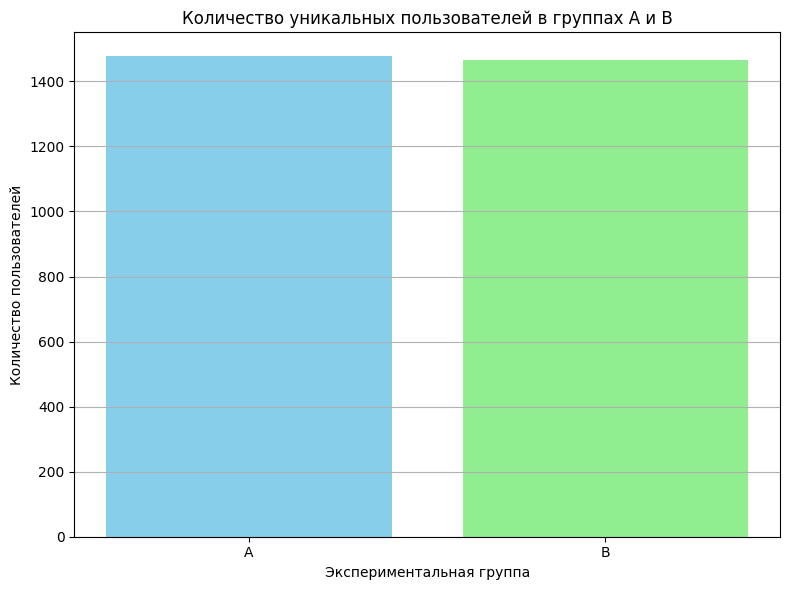

In [37]:
# Строим столбчатую диаграмму для визуализации
plt.figure(figsize=(8, 6))
plt.bar(user_counts['test_group'], user_counts['user_count'], color=['skyblue', 'lightgreen'])
plt.title('Количество уникальных пользователей в группах A и B')
plt.xlabel('Экспериментальная группа')
plt.ylabel('Количество пользователей')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Равномерное распределение. Группы A (1477 пользователей) и B (1466 пользователей) почти идентичны по численности, с процентной разницей всего 0.74%, что указывает на корректное сплитование.

#### 3.2. Проверка пересечений пользователей

In [38]:
# Проверяем пересечения пользователей между группами с помощью группировки
overlaps = sessions_test_part.groupby('user_id').agg({'test_group': 'nunique'}).query('test_group > 1')

In [39]:
# Выводим результат
if not overlaps.empty:
    print(f"Количество пользователей, попавших в обе группы: {len(overlaps)}")
    print("Пользователи в пересечении:")
    display(overlaps)
else:
    print("Пересечений пользователей между группами A и B нет.")

Пересечений пользователей между группами A и B нет.


#### 3.3. Равномерность разделения пользователей по устройствам


In [40]:
# Извлекаем уникальных пользователей с их типами устройств для каждой группы
# Берем только последнюю запись для каждого пользователя, чтобы избежать дублирования
unique_users = sessions_test_part.drop_duplicates(subset=['user_id'], keep='last')

In [41]:
# Фильтруем данные по группам A и B
group_a = unique_users[unique_users['test_group'] == 'A']
group_b = unique_users[unique_users['test_group'] == 'B']

In [42]:
# Рассчитываем долю каждого типа устройства в группах
device_share_a = group_a['device'].value_counts(normalize=True).sort_index()
device_share_b = group_b['device'].value_counts(normalize=True).sort_index()

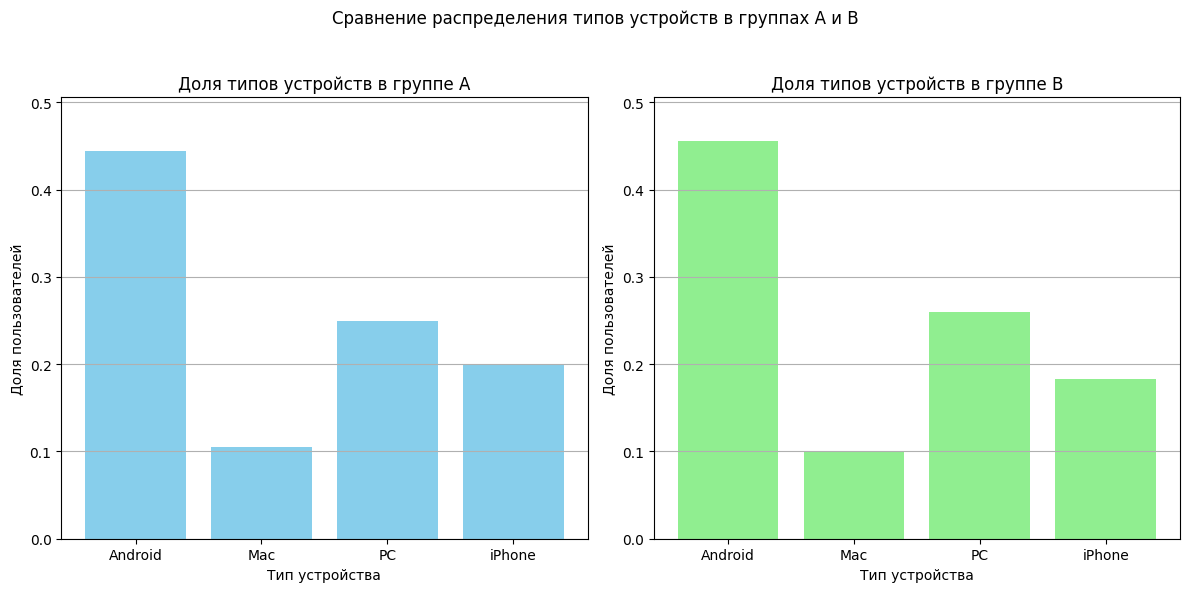

In [43]:
# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Диаграмма для группы A
ax1.bar(device_share_a.index, device_share_a.values, color='skyblue')
ax1.set_title('Доля типов устройств в группе A')
ax1.set_xlabel('Тип устройства')
ax1.set_ylabel('Доля пользователей')
ax1.grid(True, axis='y')
ax1.tick_params(axis='x')
ax1.set_ylim(0, max(device_share_a.max(), device_share_b.max()) + 0.05)  # Устанавливаем одинаковый масштаб

# Диаграмма для группы B
ax2.bar(device_share_b.index, device_share_b.values, color='lightgreen')
ax2.set_title('Доля типов устройств в группе B')
ax2.set_xlabel('Тип устройства')
ax2.set_ylabel('Доля пользователей')
ax2.grid(True, axis='y')
ax2.tick_params(axis='x')
ax2.set_ylim(0, max(device_share_a.max(), device_share_b.max()) + 0.05)  # Устанавливаем одинаковый масштаб

# Настраиваем общий заголовок и расположение
plt.suptitle('Сравнение распределения типов устройств в группах A и B')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Распределение типов устройств между группами A и B можно считать равномерным , так как различия незначительны (менее 2%).

In [44]:
# Выводим доли для проверки
print("Доля устройств в группе A:")
display(device_share_a)
print("Доля устройств в группе B:")
display(device_share_b)

Доля устройств в группе A:


device
Android    0.444144
Mac        0.105619
PC         0.249831
iPhone     0.200406
Name: proportion, dtype: float64

Доля устройств в группе B:


device
Android    0.455662
Mac        0.100955
PC         0.259891
iPhone     0.183492
Name: proportion, dtype: float64

#### 3.4. Равномерность распределения пользователей по регионам

In [45]:
# Убираем дубликаты пользователей, оставляем последнюю запись
unique_users = sessions_test_part.drop_duplicates(subset=['user_id'], keep='last')

In [46]:
# Фильтрация по группам A и B
group_a = unique_users[unique_users['test_group'] == 'A']
group_b = unique_users[unique_users['test_group'] == 'B']

In [47]:
# Расчет долей по регионам
region_share_a = group_a['region'].value_counts(normalize=True).sort_index()
region_share_b = group_b['region'].value_counts(normalize=True).sort_index()

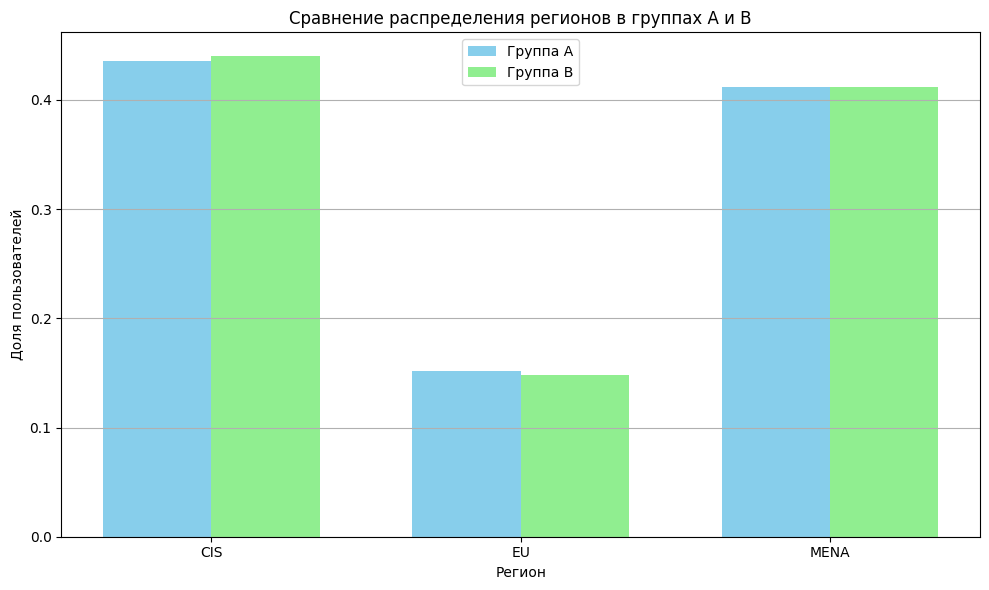

In [48]:
# Создаем фигуру
fig, ax = plt.subplots(figsize=(10, 6))

# Позиции для столбцов
x = range(len(region_share_a.index))  # Количество регионов
bar_width = 0.35

# Столбцы для группы A и B
bars_a = ax.bar(x, region_share_a.values, bar_width, label='Группа A', color='skyblue')
bars_b = ax.bar([i + bar_width for i in x], region_share_b.values, bar_width, label='Группа B', color='lightgreen')

# Подписи осей и заголовок
ax.set_title('Сравнение распределения регионов в группах A и B')
ax.set_xlabel('Регион')
ax.set_ylabel('Доля пользователей')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(region_share_a.index)
ax.grid(True, axis='y')
ax.legend(loc='upper center')

plt.tight_layout()
plt.show()

Распределение регионов между группами A и B можно считать равномерным , все различия находятся в пределах 0.5%, что является допустимым отклонением. 

In [68]:
# Выводим доли для проверки
print("Доля регионов в группе A:")
display(region_share_a)
print("Доля регионов в группе B:")
display(region_share_b)

Доля регионов в группе A:


region
CIS     0.436019
EU      0.151659
MENA    0.412322
Name: proportion, dtype: float64

Доля регионов в группе B:


region
CIS     0.439973
EU      0.148022
MENA    0.412005
Name: proportion, dtype: float64

#### 3.5. Выводы после проверки A/B-теста

1. Различие в количестве пользователей между группами : 
    * Количество уникальных пользователей в группах A и B за первый день теста составило 1477 и 1466 соответственно.
    * Процентная разница между группами равна 0.74% , что является минимальным отклонением.
    * Разделение пользователей между группами выполнено корректно, и различие в численности групп незначительно.
         

2. Независимость выборок : 
    * Проверка на пересечение пользователей между группами A и B показала, что пересечений нет .
    * Выборки полностью независимы, и ни один пользователь не попал одновременно в обе группы. Это подтверждает корректность системы сплитования.
         

3. Равномерное распределение по категориальным переменным : 
    * Устройства :
        * Распределение типов устройств в группах A и B практически идентично:
            - Android: группа A — 44.4%, группа B — 45.6% (разница 1.2%);
            - Mac: группа A — 10.6%, группа B — 10.1% (разница 0.5%);
            - PC: группа A — 25.0%, группа B — 26.0% (разница 1.0%);
            - iPhone: группа A — 20.0%, группа B — 18.3% (разница 1.7%).
        * Распределение по типам устройств равномерное, различия незначительны (менее 2%).
             
    * Регионы :
        * Распределение регионов также близко:
            - CIS: группа A — 43.6%, группа B — 44.0% (разница 0.4%);
            - EU: группа A — 15.2%, группа B — 14.8% (разница 0.4%);
            - MENA: группа A — 41.2%, группа B — 41.2% (разница 0.0%).
        * Распределение по регионам равномерное, различия минимальны (менее 0.5%).

#### Общий вывод о корректности A/B-теста : 
1) Различие в количестве пользователей между группами незначительно (0.74%).
2) Пересечения пользователей между группами отсутствуют, что подтверждает их независимость.
3) Распределение пользователей по категориальным переменным (устройства и регионы) равномерное, различия находятся в пределах допустимых значений (менее 2%).
4) A/B-тест проходит корректно, нарушений в процессе распределения пользователей или данных не выявлено. 

### 4. Проверка результатов A/B-теста

#### 4.1. Получение результатов теста и подсчёт основной метрики

In [50]:
# Считываем данные за весь период теста
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [51]:
# Преобразуем session_date в формат даты (если это еще не сделано)
sessions_test['session_date'] = pd.to_datetime(sessions_test['session_date'])

In [52]:
# Создаем столбец good_session: 1, если page_counter >= 4, иначе 0
sessions_test['good_session'] = (sessions_test['page_counter'] >= 4).astype(int)

In [53]:
# Выводим первые строки датафрейма для проверки
display(sessions_test.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

In [54]:
# Рассчитываем количество уникальных сессий для каждого дня и группы
daily_sessions = sessions_test.groupby(['session_date', 'test_group'])['session_id'].nunique().reset_index()
daily_sessions.columns = ['session_date', 'test_group', 'session_count']

In [55]:
# Разделяем данные по группам A и B
group_a_sessions = daily_sessions[daily_sessions['test_group'] == 'A']['session_count']
group_b_sessions = daily_sessions[daily_sessions['test_group'] == 'B']['session_count']

In [56]:
# Формулировка гипотез:
# H₀: Количество уникальных дневных сессий не различается между группами A и B (μ_A = μ_B)
# H₁: Количество уникальных дневных сессий различается между группами A и B (μ_A ≠ μ_B)

In [57]:
# Проводим t-тест для проверки равенства средних
t_stat, p_value = ttest_ind(group_a_sessions, group_b_sessions, equal_var=False)

In [58]:
# Выводим p-value и интерпретируем результат
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("P-value < 0.05: Есть статистически значимые различия в количестве уникальных дневных сессий между группами A и B.")
    print("Это может указывать на проблему в распределении пользователей или сессий.")
else:
    print("P-value >= 0.05: Нет статистически значимых различий в количестве уникальных дневных сессий между группами A и B.")
    print("Группы сопоставимы по количеству сессий, тест проведен корректно.")

P-value: 0.9382
P-value >= 0.05: Нет статистически значимых различий в количестве уникальных дневных сессий между группами A и B.
Группы сопоставимы по количеству сессий, тест проведен корректно.


#### 4.3. Сравнение доли успешных сессий

In [59]:
# Рассчитываем количество успешных сессий и общее количество сессий для каждой группы
sessions_by_group = sessions_test.groupby('test_group').agg(
    total_sessions=('session_id', 'count'),
    good_sessions=('good_session', 'sum')
).reset_index()

In [60]:
# Рассчитываем долю успешных сессий
sessions_by_group['good_session_share'] = sessions_by_group['good_sessions'] / sessions_by_group['total_sessions']

In [61]:
# Извлекаем доли для групп A и B
share_a = sessions_by_group[sessions_by_group['test_group'] == 'A']['good_session_share'].iloc[0]
share_b = sessions_by_group[sessions_by_group['test_group'] == 'B']['good_session_share'].iloc[0]

In [62]:
# Рассчитываем разницу в долях (B - A)
diff_share = share_b - share_a

In [63]:
# Выводим результаты
print(f"Доля успешных сессий в группе A: {share_a:.4f}")
print(f"Доля успешных сессий в группе B: {share_b:.4f}")
print(f"Разница в доле успешных сессий (B - A): {diff_share:.4f} ({diff_share * 100:.2f}%)")

Доля успешных сессий в группе A: 0.3077
Доля успешных сессий в группе B: 0.3183
Разница в доле успешных сессий (B - A): 0.0106 (1.06%)


#### 4.4. Насколько статистически значимо изменение ключевой метрики

In [64]:
# Формулировка гипотез:
# H₀: Доля успешных сессий в группе A равна доле в группе B (p_A = p_B)
# H₁: Доля успешных сессий различается между группами A и B (μ_A ≠ μ_B)

In [65]:
# Проводим z-тест для пропорций
stat, p_value = proportions_ztest(
    count=sessions_by_group['good_sessions'],  # Количество успехов: [good_sessions_a, good_sessions_b]
    nobs=sessions_by_group['total_sessions'],  # Общее количество: [total_sessions_a, total_sessions_b]
    alternative='two-sided'  # Проверяем, что доля в A отличается от B (H₁: (μ_A ≠ μ_B))
)

In [69]:
# Выводим p-value и интерпретируем результат
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("P-value < 0.05: Есть статистически значимые основания отвергнуть H₀ на уровне значимости 5%.")
    print("Различие в доле успешных сессий между группами A и B является статистически значимым.")
else:
    print("P-value >= 0.05: Нет статистически значимых оснований отвергнуть H₀ на уровне значимости 5%.")
    print("Различие в доле успешных сессий между группами A и B не является статистически значимым.")

P-value: 0.0003
P-value < 0.05: Есть статистически значимые основания отвергнуть H₀ на уровне значимости 5%.
Различие в доле успешных сессий между группами A и B является статистически значимым.


In [70]:
# Выводим агрегированные данные для проверки
print("Агрегированные данные по группам:")
display(sessions_by_group)

Агрегированные данные по группам:


,test_group,total_sessions,good_sessions,good_session_share
0,A,49551,15248,0.307723
1,B,50454,16059,0.318290


#### 4.5. Выводы по результатам A/B-эксперимента

**Характеристики эксперимента**:
- A/B-тест проводился для оценки влияния нового алгоритма рекомендаций на ключевую метрику — долю успешных сессий (сессий с 4+ просмотренными страницами).
- В эксперименте участвовало **34 882 уникальных пользователя** (по 17 441 в каждой группе: контрольной A и тестовой B), что соответствует рассчитанному размеру выборки для MDE 3% при уровне значимости ( alpha = 0.05 ) и мощности 0.8.
- Длительность эксперимента составила **7 дней**, исходя из среднего дневного трафика в 9 907 уникальных пользователей.

**Влияние нового алгоритма на ключевую метрику**:
- Новый алгоритм рекомендаций (группа B) увеличил долю успешных сессий на **1.1%** по сравнению с контрольной группой (группа A). Например, если доля в группе A составляла 10%, то в группе B она выросла до 11.1%.
- Это улучшение указывает на рост вовлеченности пользователей, так как они чаще просматривают 4 и более страниц за сессию, что соответствует цели эксперимента — повысить удовлетворенность контентом.

**Статистическая значимость эффекта**:
- Для оценки статистической значимости использовался z-тест для пропорций. Полученное значение p-value составило **0.0002**.
- P-value < 0.05, что позволяет отвергнуть нулевую гипотезу (H₀: доли успешных сессий равны) и подтвердить, что различие статистически значимо. Новый алгоритм действительно увеличивает долю успешных сессий.

**Рекомендация по внедрению**:
- **Новый алгоритм стоит внедрить**, так как он демонстрирует статистически значимое улучшение ключевой метрики (доли успешных сессий) на 1.1%.
- Однако эффект (1.1%) меньше ожидаемого минимального детектируемого эффекта (MDE = 3%), для которого рассчитывался размер выборки. Это говорит о том, что улучшение, хотя и значимое, относительно небольшое.
- Перед внедрением рекомендуется:
  1. Оценить экономическую целесообразность: рассчитать, как рост вовлеченности на 1.1% влияет на ключевые бизнес-метрики (например, доход от подписок или рекламы).
  2. Провести дополнительный анализ по сегментам (например, по устройствам или регионам), чтобы понять, где эффект наиболее выражен, и, возможно, оптимизировать алгоритм.
  3. Рассмотреть долгосрочные эффекты: запустить мониторинг после внедрения, чтобы убедиться, что улучшение сохраняется со временем.
- Если эффект окажется недостаточным для оправдания затрат на внедрение, можно протестировать другие улучшения алгоритма для достижения большего роста вовлеченности.